## Crude Oil Price Forecasting using timeseries analysis

data source : https://www.investing.com/commodities/crude-oil-historical-data

model type : recurrent neural network (RNN) with long short term memory (LSTM)

pre-requisite : https://chromedriver.chromium.org/downloads 

In [18]:
# import necessary libraries
import pandas as pd
from selenium import webdriver
import time
import matplotlib.pyplot as plt
import numpy as np

In [19]:
pip install selenium

Note: you may need to restart the kernel to use updated packages.


### Data Mining

In [20]:
# to scrap a dynamic webpage , selenimum webdriver is required
# for the function to work on other system, download webdriver for your platform from 
# https://chromedriver.chromium.org/downloads 
# unzip the downloaded file and place the chromewebdriver and copy the path
# Update the line browser = webdriver.Chrome('path_to_webdriver')

# following function scraps webdata and return pandas dataframe
def scrap_historical_data():
    # instantiate chrome webdriver
    browser = webdriver.Chrome('c:\Roi\chromedriver.exe')
    url = 'https://www.investing.com/commodities/crude-oil-historical-data'

    browser.get(url)
    # add wait time for the webpage to load
    time.sleep(10)
    # remove any popups
    try:
        popup = browser.find_element_by_xpath('//*[@id="PromoteSignUpPopUp"]/div[2]/i')
        popup.click()
    except:
        pass
    field = browser.find_element_by_xpath('//*[@id="widgetFieldDateRange"]')
    field.click()
    # add wait time for the webpage to load
    time.sleep(2)
    # set date limit to which historical data is considered
    start_date = browser.find_element_by_xpath('//*[@id="startDate"]')
    start_date.clear()
    start_date.send_keys('01/01/2000')
    enter_key = browser.find_element_by_xpath('//*[@id="applyBtn"]')
    enter_key.click()
    # add wait time for the webpage to load
    time.sleep(10)
    # remove any popups
    try:
        popup = browser.find_element_by_xpath('//*[@id="PromoteSignUpPopUp"]/div[2]/i')
        popup.click()
    except:
        pass
    # load the data from webpage
    try:
        tabel = browser.find_element_by_xpath('//*[@id="curr_table"]').get_attribute('outerHTML')
    except:
        # remove any popups
        try:
            popup = browser.find_element_by_xpath('//*[@id="PromoteSignUpPopUp"]/div[2]/i')
            popup.click()
        except:
            pass
        # load the data from webpage
        tabel = browser.find_element_by_xpath('//*[@id="curr_table"]').get_attribute('outerHTML')
    df  = pd.read_html(tabel)
    dataset = df[0]
    # save a copy of data scarpped into local directory
    dataset.to_csv('crude_oil_price_history.csv')
    return dataset

In [21]:
# invoke scrapping function
main_dataset = scrap_historical_data()
# parse data in scrapped data to standard timestamp format
main_dataset.loc[:,'Date'] = pd.to_datetime(main_dataset.loc[:,'Date'])
# Drop columns that are not needed to do prediction
main_dataset.drop(columns=['Open','High','Low','Vol.','Change %'], inplace=True, axis=1)
# Display the sample to see how dataframe looks now
print(main_dataset)

           Date  Price
0    2019-08-23  54.17
1    2019-08-22  55.35
2    2019-08-21  55.68
3    2019-08-20  56.34
4    2019-08-19  56.21
...         ...    ...
4995 2000-01-10  24.67
4996 2000-01-07  24.22
4997 2000-01-06  24.78
4998 2000-01-05  24.91
4999 2000-01-04  25.55

[5000 rows x 2 columns]


# Data Cleaning

In [ ]:
# set index of the datafarme as timestamp
cleaned_dataset = main_dataset.set_index('Date')
# downsample the data to fix the data frequency 
# dataframe now contains crudeoil price for once in 3 days
# upsample is not done since it will add noise to the data
resample = cleaned_dataset.resample('3D').ffill()

# isolate test data from training data
real_data = resample.iloc[-12:,:]
test_data = resample.iloc[-24:-12,:]

# create the masked sample which doesn't contain the test data
masked_resample = resample.iloc[:-24,:]

### Feature Engineering

In [7]:
# adding sliding window for creation of forecasting model
# the forecasting model will take 12 previous data points of crude oil price and forecast future 12 datapoints
masked_resample['Price+1'] = masked_resample['Price'].shift(-1)
masked_resample['Price+2'] = masked_resample['Price'].shift(-2)
masked_resample['Price+3'] = masked_resample['Price'].shift(-3)
masked_resample['Price+4'] = masked_resample['Price'].shift(-4)
masked_resample['Price+5'] = masked_resample['Price'].shift(-5)
masked_resample['Price+6'] = masked_resample['Price'].shift(-6)
masked_resample['Price+7'] = masked_resample['Price'].shift(-7)
masked_resample['Price+8'] = masked_resample['Price'].shift(-8)
masked_resample['Price+9'] = masked_resample['Price'].shift(-9)
masked_resample['Price+10'] = masked_resample['Price'].shift(-10)
masked_resample['Price+11'] = masked_resample['Price'].shift(-11)
masked_resample['Price+12'] = masked_resample['Price'].shift(-12)
masked_resample['Price+13'] = masked_resample['Price'].shift(-13)
masked_resample['Price+14'] = masked_resample['Price'].shift(-14)
masked_resample['Price+15'] = masked_resample['Price'].shift(-15)
masked_resample['Price+16'] = masked_resample['Price'].shift(-16)
masked_resample['Price+17'] = masked_resample['Price'].shift(-17)
masked_resample['Price+18'] = masked_resample['Price'].shift(-18)
masked_resample['Price+19'] = masked_resample['Price'].shift(-19)
masked_resample['Price+20'] = masked_resample['Price'].shift(-20)
masked_resample['Price+21'] = masked_resample['Price'].shift(-21)
masked_resample['Price+22'] = masked_resample['Price'].shift(-22)
masked_resample['Price+23'] = masked_resample['Price'].shift(-23)
# drop the trailing row which contains NaN and cleanup the masked sample
masked_resample.dropna(inplace=True)
masked_resample.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7,Price+8,Price+9,...,Price+14,Price+15,Price+16,Price+17,Price+18,Price+19,Price+20,Price+21,Price+22,Price+23
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,25.55,24.22,24.67,26.69,28.02,29.54,28.20,28.28,27.22,27.64,...,30.06,29.51,29.51,29.97,30.35,31.77,31.51,34.13,31.76,32.02
2000-01-07,24.22,24.67,26.69,28.02,29.54,28.20,28.28,27.22,27.64,28.03,...,29.51,29.51,29.97,30.35,31.77,31.51,34.13,31.76,32.02,31.09
2000-01-10,24.67,26.69,28.02,29.54,28.20,28.28,27.22,27.64,28.03,28.82,...,29.51,29.97,30.35,31.77,31.51,34.13,31.76,32.02,31.09,30.91
2000-01-13,26.69,28.02,29.54,28.20,28.28,27.22,27.64,28.03,28.82,28.77,...,29.97,30.35,31.77,31.51,34.13,31.76,32.02,31.09,30.91,27.46
2000-01-16,28.02,29.54,28.20,28.28,27.22,27.64,28.03,28.82,28.77,29.44,...,30.35,31.77,31.51,34.13,31.76,32.02,31.09,30.91,27.46,28.02


### Feature Normalization

In [8]:
#normalize all the features for the machine learning model to learn fast
from sklearn.preprocessing import MinMaxScaler
sc_X = MinMaxScaler()
sc_y = MinMaxScaler()
X = sc_X.fit_transform(masked_resample.iloc[:,0:12])
y = sc_y.fit_transform(masked_resample.iloc[:,12:])

### Define Independant and Dependant Variables

In [9]:
# reshape the input features (X) to a 3D input for the RNN (recurrent neural network) to feed on
X_train = X.reshape(X.shape[0],1,X.shape[1])
y_train = y

### Deep Learning Model Definition

In [10]:
# Recurrent Neural Netowrk (RNN) with Long Short Term Memory (LSTM)
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 30, return_sequences = True, input_shape = (None, X_train.shape[2])))
# Adding a second LSTM layer
regressor.add(LSTM(units = 30, return_sequences = True))
# Adding a third LSTM layer
regressor.add(LSTM(units = 30, return_sequences = True))
# Adding a fourth LSTM layer
regressor.add(LSTM(units = 30))
# Adding the output layer
regressor.add(Dense(units = y_train.shape[1]))

# Compiling the RNN
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
regressor.summary()

Using TensorFlow backend.






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 30)          5160      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 30)          7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 30)          7320      
_________________________________________________________________
lstm_4 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                372       
Total params: 27,492
Trainable params: 27,492
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [13]:
# Fitting the RNN to the Training set (actual training happens here)
regressor.fit(X_train, y_train, epochs = 32, batch_size = 64)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/32





2344/2344 [==============================] - 10s 4ms/step - loss: 0.1120
Epoch 2/32
2344/2344 [==============================] - 1s 303us/step - loss: 0.0135
Epoch 3/32
2344/2344 [==============================] - 1s 337us/step - loss: 0.0034
Epoch 4/32
2344/2344 [==============================] - 1s 351us/step - loss: 0.0029
Epoch 5/32
2344/2344 [==============================] - 1s 341us/step - loss: 0.0028
Epoch 6/32
2344/2344 [==============================] - 1s 361us/step - loss: 0.0028
Epoch 7/32
2344/2344 [==============================] - 1s 334us/step - loss: 0.0027
Epoch 8/32
2344/2344 [==============================] - 1s 315us/step - loss: 0.0027
Epoch 9/32
2344/2344 [==============================] - 1s 320us/step - loss: 0.0025
Epoch 10/32
2344/2344 [==============================] - 1s 314us/step - loss: 0.0026
Epoch 11/32
2344/2344 [=========================

### Model Testing and Test Result Vizualization

In [11]:
# do prediction on test data
test_input = sc_X.transform(np.array(test_data['Price']).reshape(1,-1))
prediction = sc_y.inverse_transform(regressor.predict(test_input.reshape(test_input.shape[0],1,test_input.shape[1])))

__main__:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<function matplotlib.pyplot.show(*args, **kw)>

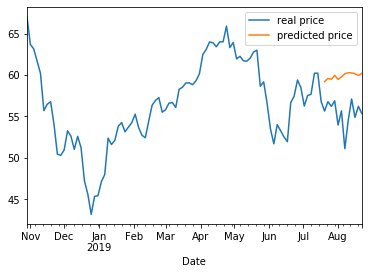

In [15]:
# vizulaization on test data prediction
real_data['prediction'] = prediction.reshape(-1,1)
plotting = resample[['Price']]
plotting['predicted'] = real_data['prediction'] 
plotting.columns = ['real price', 'predicted price']
plotting.iloc[-100:,:].plot.line()
plt.show

### Forecast for next 12 datapoints

In [12]:
letest_prices = sc_X.transform(np.array(real_data['Price']).reshape(1,-1))
forecast = sc_y.inverse_transform(regressor.predict(letest_prices.reshape(test_input.shape[0],1,letest_prices.shape[1])))

### Forecast Vizualization

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1219: FutureWarning: Addition/subtraction of integers and integer-arrays to DatetimeArray is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  maybe_integer_op_deprecated(self)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


<function matplotlib.pyplot.show(*args, **kw)>

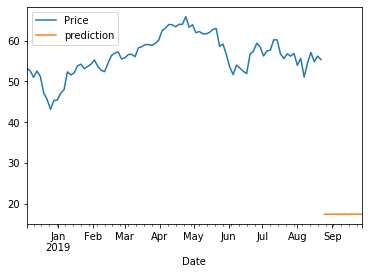

In [13]:
forecast_df = pd.DataFrame(forecast.reshape(-1,1))
forecast_df.index = real_data.index + 12
forecast_df.columns=['prediction']
forecast_df['Price'] = np.nan
f_plotting = resample[['Price']]
f_plotting['prediction'] = np.nan
f_plotting = pd.concat([f_plotting, forecast_df], axis=0)
f_plotting.iloc[-100:,:].plot.line()
plt.show

In [14]:
forecast_df.drop(columns=['Price'], axis=1).to_csv('forecast.csv')

In [15]:
forecast_df.drop(columns=['Price'], axis=1).to_csv('forecast.csv')